In [4]:
import cv2, numpy as np, pandas as pd, math, os
from matplotlib import pyplot as plt

mode = 'synthetic'


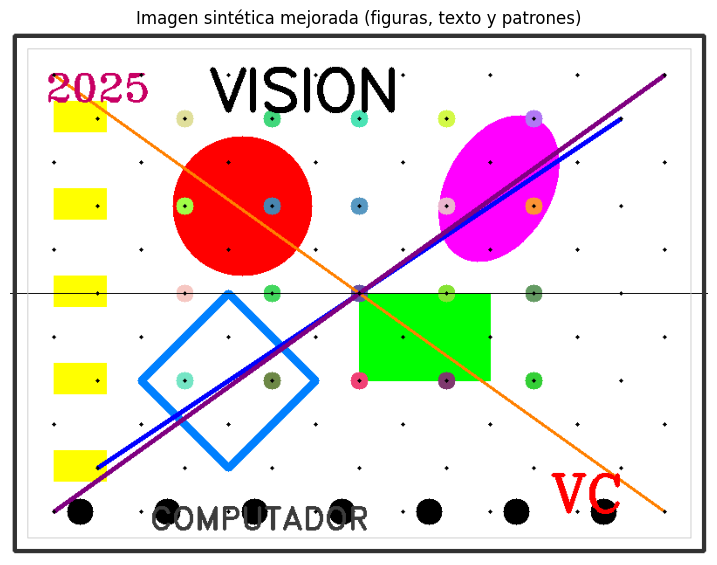

In [5]:
def create_synthetic_pair(img, angle_deg=10, tx=30, ty=20, scale=1.05):
    h, w = img.shape[:2]
    cx, cy = w/2, h/2
    angle = math.radians(angle_deg)

    T1 = np.array([[1,0,-cx],[0,1,-cy],[0,0,1]])
    R = np.array([[math.cos(angle), -math.sin(angle), 0],[math.sin(angle), math.cos(angle),0],[0,0,1]])
    S = np.array([[scale,0,0],[0,scale,0],[0,0,1]])
    T2 = np.array([[1,0,cx+tx],[0,1,cy+ty],[0,0,1]], dtype=float)

    H = T2 @ S @ R @ T1
    dst = cv2.warpPerspective(img, H, (w, h))
    return img, dst, H

def create_geometric_base(w=800, h=600):
    """Crea una imagen sintética rica en detalles geométricos, texto y patrones."""
    img = np.ones((h, w, 3), dtype=np.uint8) * 255  # Fondo blanco

    # --- Figuras grandes ---
    cv2.circle(img, (w//3, h//3), 80, (0, 0, 255), -1)  # Círculo rojo
    cv2.rectangle(img, (w//2, h//2), (w//2+150, h//2+100), (0, 255, 0), -1)  # Rectángulo verde
    cv2.ellipse(img, (int(w*0.7), int(h*0.3)), (60, 90), 30, 0, 360, (255, 0, 255), -1)  # Elipse magenta
    cv2.polylines(img, [np.array([[150,400],[250,300],[350,400],[250,500]], np.int32)], True, (255,128,0), 8)  # Rombo naranja

    # --- Patrón de círculos en distintas zonas ---
    for y in range(100, h-100, 100):
        for x in range(100, w-100, 100):
            color = (np.random.randint(50,255), np.random.randint(50,255), np.random.randint(50,255))
            cv2.circle(img, (x, y), 10, color, -1)

    # --- Pequeños detalles geométricos ---
    for i in range(80, 750, 100):
        cv2.circle(img, (i, 550), 15, (0, 0, 0), -1)  # Círculos negros
    for j in range(80, 500, 100):
        cv2.rectangle(img, (50, j), (110, j+35), (0, 255, 255), -1)  # Rectángulos amarillos

    # --- Líneas y diagonales ---
    cv2.line(img, (100, 500), (700, 100), (255, 0, 0), 4)
    cv2.line(img, (50, 50), (750, 550), (0, 128, 255), 2)
    cv2.line(img, (50, 550), (750, 50), (128, 0, 128), 3)
    cv2.line(img, (0, h//2), (w, h//2), (0, 0, 0), 1)  # Línea central horizontal

    # --- Texto en diferentes estilos y posiciones ---
    cv2.putText(img, 'VISION', (230, 90), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (0, 0, 0), 6)
    cv2.putText(img, 'COMPUTADOR', (160, 570), cv2.FONT_HERSHEY_DUPLEX, 1.2, (60, 60, 60), 2)
    cv2.putText(img, 'VC', (w-180, h-50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 3)
    cv2.putText(img, '2025', (40, 80), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (100, 0, 200), 2)

    # --- Rejilla de puntos para textura ---
    for y in range(50, h, 50):
        for x in range(50, w, 50):
            if (x+y) % 100 == 0:
                cv2.circle(img, (x, y), 2, (0, 0, 0), -1)

    # --- Bordes decorativos dobles ---
    cv2.rectangle(img, (5, 5), (w-5, h-5), (50, 50, 50), 3)
    cv2.rectangle(img, (20, 20), (w-20, h-20), (200, 200, 200), 1)

    return img

# Crear y visualizar la base geométrica
base = create_geometric_base()
plt.figure(figsize=(9,7))
plt.imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
plt.title("Imagen sintética mejorada (figuras, texto y patrones)")
plt.axis('off')
plt.show()


In [6]:
def rmse_points(A, B):
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    return np.sqrt(np.mean(np.sum((A-B)**2, axis=1)))

def rotation_angle_from_homography(H):
    a, b = H[0,0], H[0,1]
    return math.degrees(math.atan2(b, a))

def get_detector(name):
    if name == 'sift':
        try: return cv2.SIFT_create()
        except: return None
    elif name == 'orb':
        return cv2.ORB_create(1500)
    elif name == 'akaze':
        return cv2.AKAZE_create()
    else:
        return None

def match_and_estimate(kpsA, desA, kpsB, desB, det_name):
    norm = cv2.NORM_L2 if det_name in ['sift','akaze'] else cv2.NORM_HAMMING
    bf = cv2.BFMatcher(norm)
    knn = bf.knnMatch(desA, desB, k=2)
    good = []
    for m, n in knn:
        if m.distance < 0.75*n.distance:
            good.append(m)
    if len(good) < 4:
        return None, None, []
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in good])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in good])
    Hest, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4.0)
    return Hest, mask, good

In [7]:
!pip install imageio


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


GIF guardado en: ../base/synthetic_transforms.gif


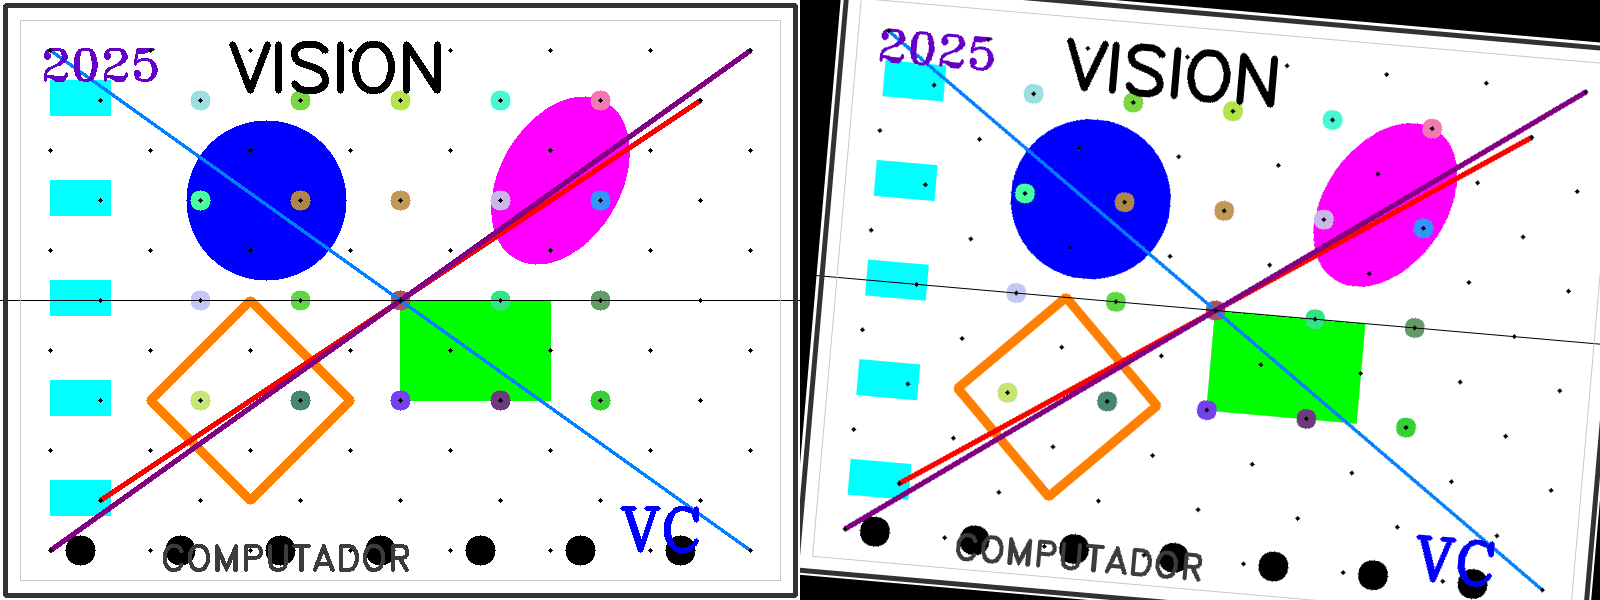

In [11]:
import imageio
from IPython.display import Image, display

# --- Transformaciones sintéticas ---
transforms = [
    {'angle_deg': 5,  'tx': 15,  'ty': 10,  'scale': 1.00},
    {'angle_deg': 15, 'tx': 40,  'ty': -25, 'scale': 1.02},
    {'angle_deg': -20,'tx': -30, 'ty': 25,  'scale': 0.95},
    {'angle_deg': 30, 'tx': 10,  'ty': -15, 'scale': 1.10},
    {'angle_deg': -10,'tx': -40, 'ty': 30,  'scale': 0.90},
]

detectors = ['sift','orb','akaze']
results = []

# --- Visualización individual + construcción del GIF ---
frames = []
for t in transforms:
    A, B, Htrue = create_synthetic_pair(base, **t)
    combined = np.hstack([A, B])
    frames.append(combined)

gif_path = '../base/synthetic_transforms.gif'
imageio.mimsave(gif_path, frames, fps=1)
print(f"GIF guardado en: {gif_path}")
display(Image(filename=gif_path))

# --- Evaluación con detectores ---
for det_name in detectors:
    det = get_detector(det_name)
    if det is None:
        print(f"Detector {det_name} no disponible.")
        continue
    for t in transforms:
        A, B, Htrue = create_synthetic_pair(base, **t)
        grayA, grayB = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY), cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
        kpsA, desA = det.detectAndCompute(grayA, None)
        kpsB, desB = det.detectAndCompute(grayB, None)
        Hest, mask, good = match_and_estimate(kpsA, desA, kpsB, desB, det_name)
        
        if Hest is None:
            rmse_val, angle_err, inliers = np.nan, np.nan, 0
        else:
            pts = np.float32([
                [0,0],
                [0,A.shape[0]-1],
                [A.shape[1]-1,A.shape[0]-1],
                [A.shape[1]-1,0]
            ]).reshape(-1,1,2)
            
            pts_true = cv2.perspectiveTransform(pts, Htrue).reshape(-1,2)
            pts_est = cv2.perspectiveTransform(pts, Hest).reshape(-1,2)
            
            rmse_val = rmse_points(pts_true, pts_est)
            angle_true = rotation_angle_from_homography(Htrue)
            angle_est = rotation_angle_from_homography(Hest)
            angle_err = abs(angle_true - angle_est)
            inliers = int(mask.sum()) if mask is not None else 0
        
        results.append({
            'detector': det_name,
            'angle_true': t['angle_deg'],
            'tx': t['tx'],
            'ty': t['ty'],
            'scale': t['scale'],
            'n_kp_A': len(kpsA),
            'n_kp_B': len(kpsB),
            'n_matches': len(good),
            'inliers': inliers,
            'rmse_px': rmse_val,
            'angle_err_deg': angle_err
        })



In [ ]:
output_dir = r'C:\Users\juanj\Downloads\VisionComputador\Trabajo 2'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'detector_validation.csv')

In [ ]:
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f'Resultados guardados en: {output_path}')
df

Resultados guardados en: C:\Users\juanj\Downloads\VisionComputador\Trabajo 2\detector_validation.csv


detector  angle_true  tx  ty  scale  n_kp_A  n_kp_B  n_matches  inliers  \
0      sift           5  15  10   1.00     839    1358        397      358   
1      sift          15  40 -25   1.02     839    1140        302      262   
2      sift         -20 -30  25   0.95     839    1082        342      282   
3      sift          30  10 -15   1.10     839    1041        250      199   
4      sift         -10 -40  30   0.90     839    1195        326      256   
5       orb           5  15  10   1.00    1503    1500        684      549   
6       orb          15  40 -25   1.02    1503    1500        431      307   
7       orb         -20 -30  25   0.95    1503    1500        408      327   
8       orb          30  10 -15   1.10    1503    1500        284      159   
9       orb         -10 -40  30   0.90    1503    1500        413      284   
10    akaze           5  15  10   1.00    1224    1125        775      735   
11    akaze          15  40 -25   1.02    1224    1045        563      518   
12    akaze         -20 -30  25   0.95    1224     970        565      528   
13    akaze          30  10 -15   1.10    1224     948        304      244   
14    akaze         -10 -40  30   0.90    1224     983        371      328   

     rmse_px  angle_err_deg  
0   0.115078       0.009353  
1   0.333640       0.003870  
2   0.164840       0.024786  
3   0.299079       0.020445  
4   0.195776       0.002542  
5   0.634680       0.044212  
6   0.433843       0.013707  
7   0.559756       0.112057  
8   3.404844       0.114389  
9   0.452107       0.006411  
10  0.097426       0.002344  
11  0.084728       0.009942  
12  0.141922       0.003527  
13  0.627570       0.027312  
14  0.357346       0.045236

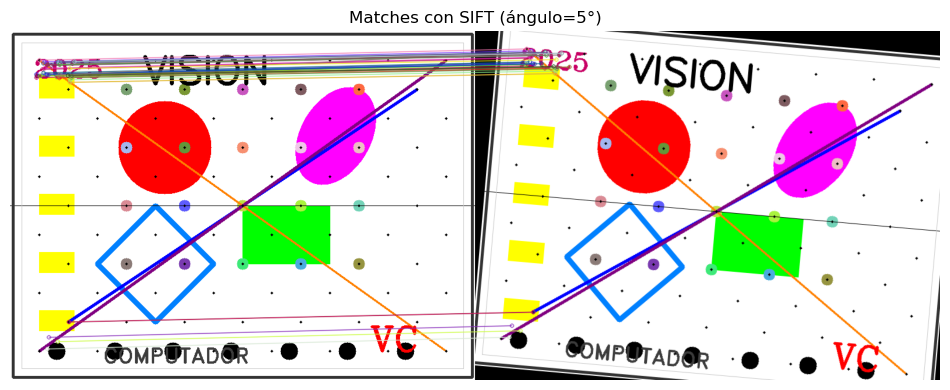

In [ ]:
sample = df.dropna().iloc[0]
det_name = sample['detector']
t = {'angle_deg': sample['angle_true'], 'tx': sample['tx'], 'ty': sample['ty'], 'scale': sample['scale']}
A,B,Htrue = create_synthetic_pair(base, **t)
det = get_detector(det_name)
grayA, grayB = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY), cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
kpsA, desA = det.detectAndCompute(grayA, None)
kpsB, desB = det.detectAndCompute(grayB, None)
Hest, mask, good = match_and_estimate(kpsA, desA, kpsB, desB, det_name)
img_matches = cv2.drawMatches(A, kpsA, B, kpsB, good[:40], None, flags=2)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'Matches con {det_name.upper()} (ángulo={t["angle_deg"]}°)')
plt.axis('off')
plt.show()

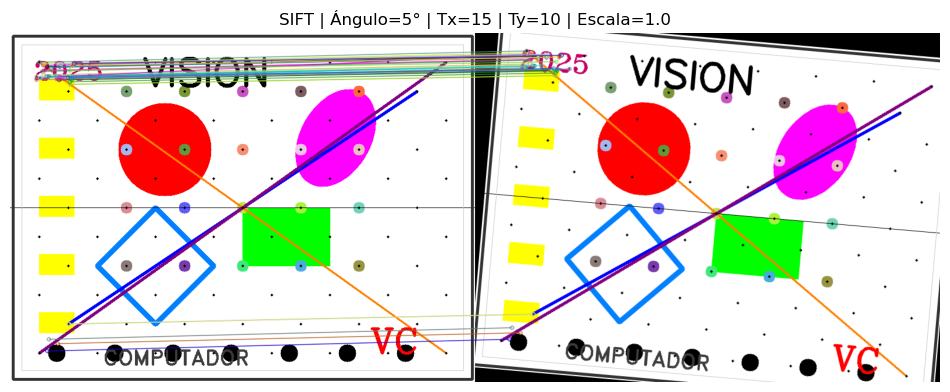

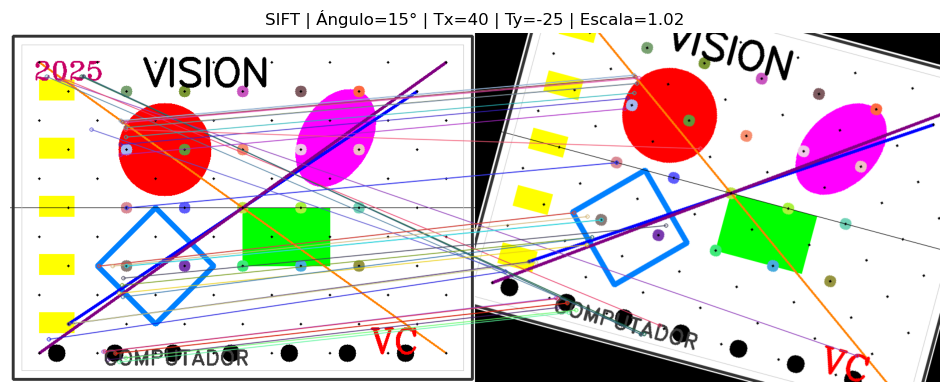

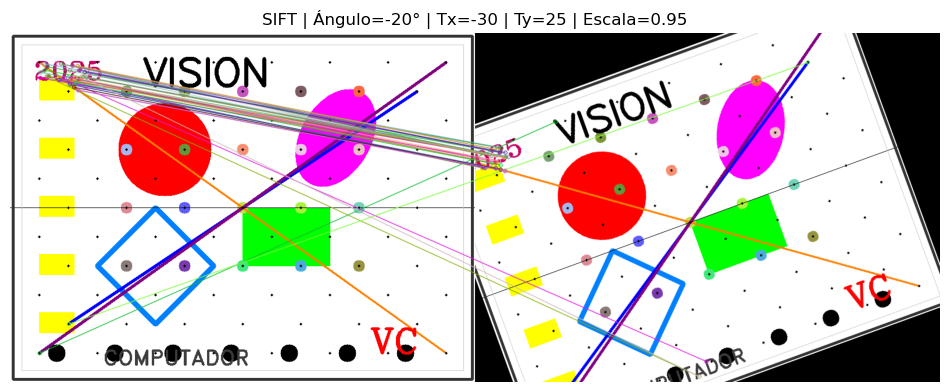

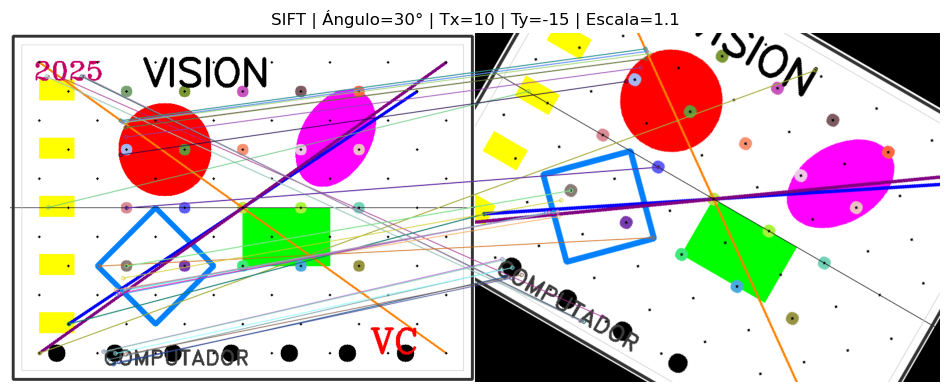

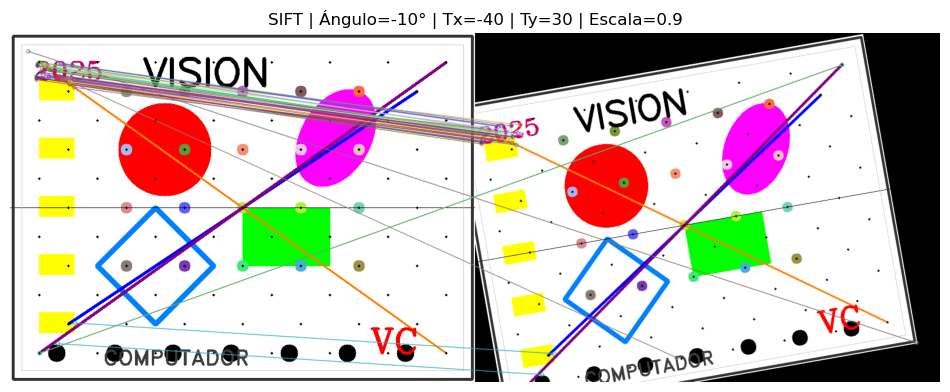

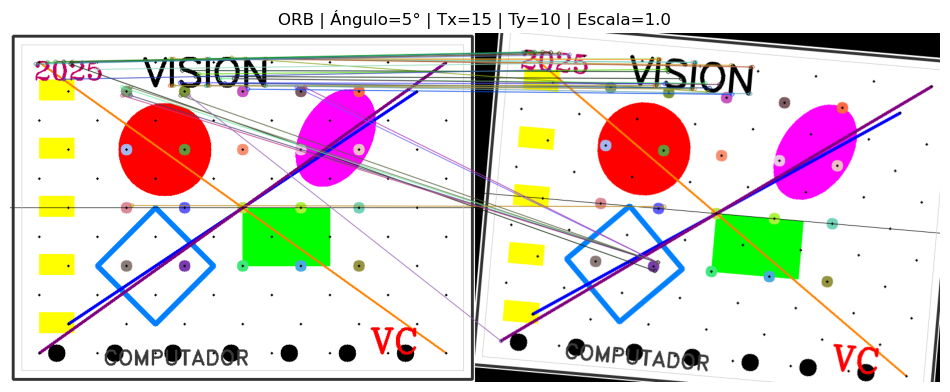

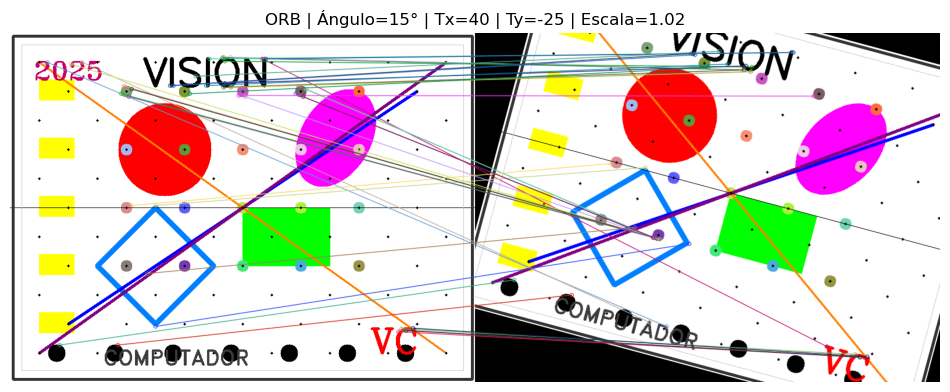

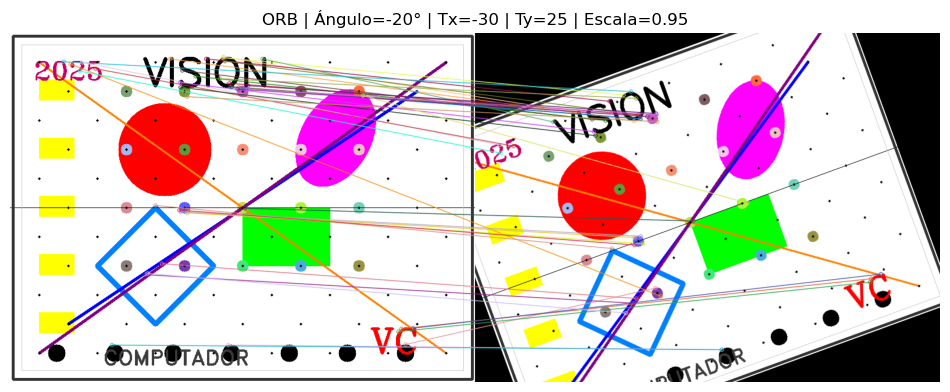

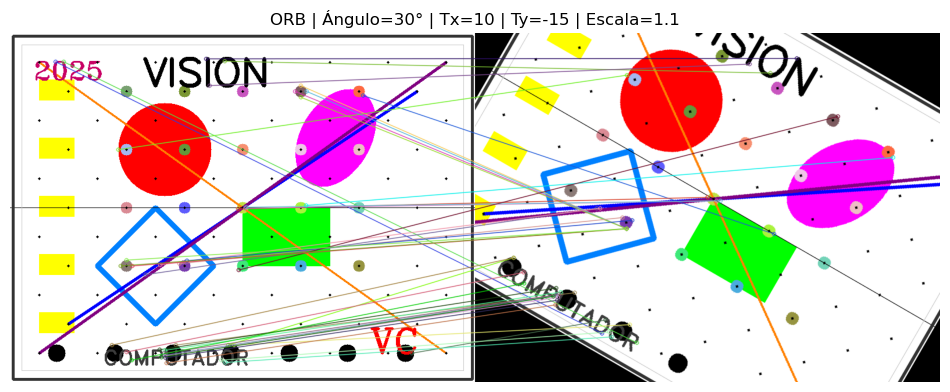

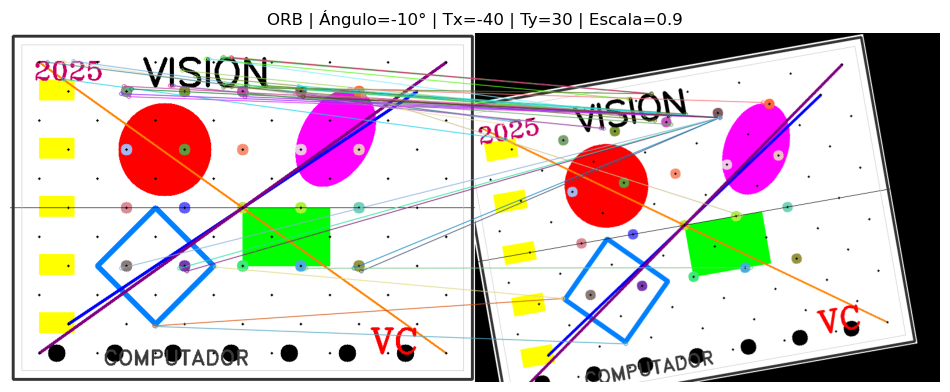

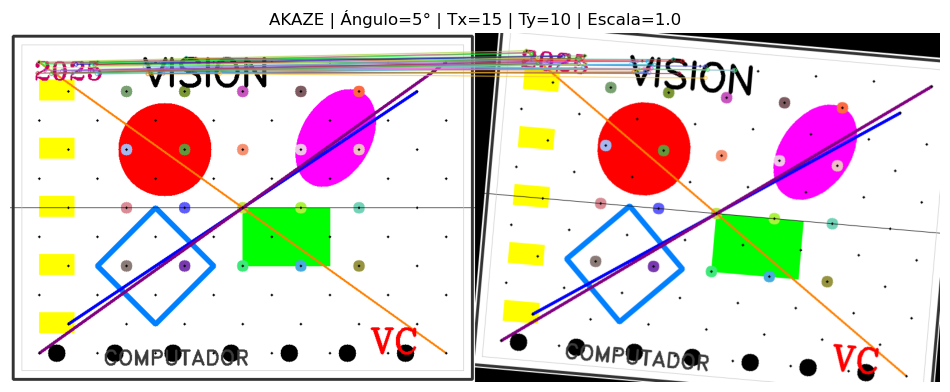

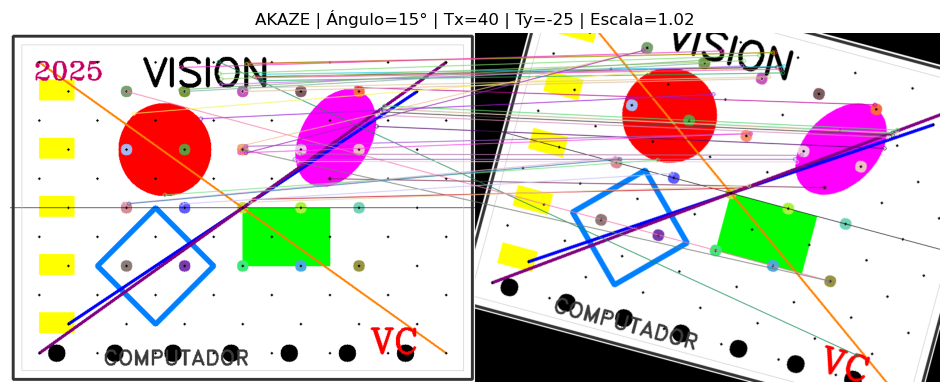

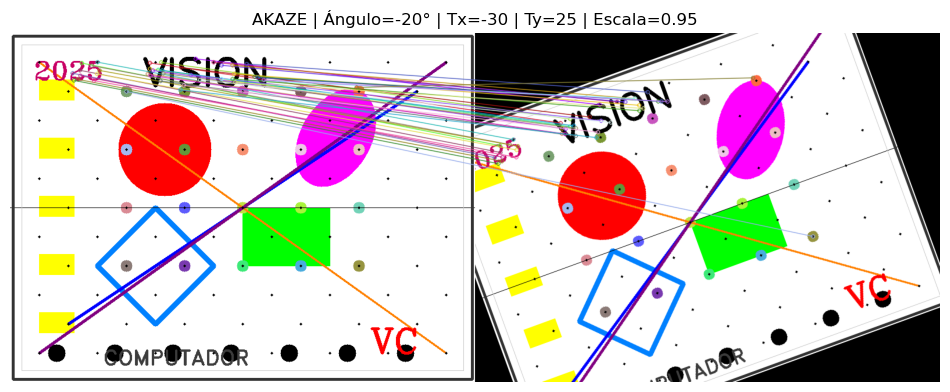

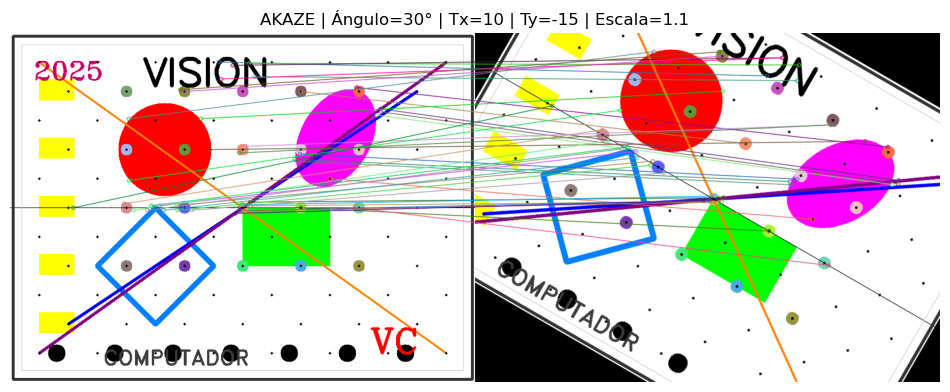

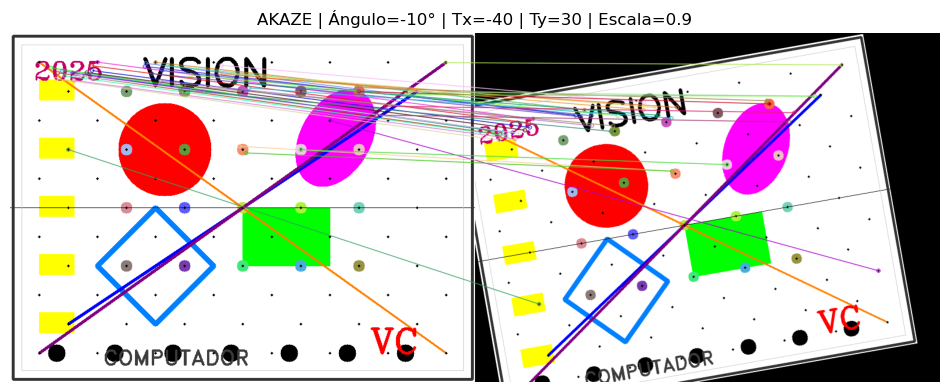

In [ ]:
# --- Mostrar matches para TODAS las transformaciones válidas ---
df_valid = df.dropna(subset=['rmse_px', 'angle_err_deg']).copy()

for i, row in df.iterrows():
    det_name = row['detector']
    t = {
        'angle_deg': row['angle_true'],
        'tx': row['tx'],
        'ty': row['ty'],
        'scale': row['scale']
    }
    A, B, Htrue = create_synthetic_pair(base, **t)
    det = get_detector(det_name)
    grayA, grayB = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY), cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
    kpsA, desA = det.detectAndCompute(grayA, None)
    kpsB, desB = det.detectAndCompute(grayB, None)
    Hest, mask, good = match_and_estimate(kpsA, desA, kpsB, desB, det_name)

    if good is None or len(good) == 0:
        title = f"{det_name.upper()} | Falló el emparejamiento"
        img_matches = np.hstack([A, B])  # solo muestra las imágenes lado a lado
    else:
        img_matches = cv2.drawMatches(
            A, kpsA, B, kpsB, good[:40], None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        title = f"{det_name.upper()} | Ángulo={t['angle_deg']}° | Tx={t['tx']} | Ty={t['ty']} | Escala={t['scale']}"

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()